# Misha's bird

In [1]:
from maliboo import BayesianOptimization, UtilityFunction
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import pandas as pd
import time

import warnings

In [2]:
# DEFINE NUMBER OF INITIAL POINTS

ninit = 10

In [3]:
# DEFINE TARGET AND CONTRAINTS: MISHRA'S BIRD 

def target(x,y):
    return -(np.sin(y)*np.exp((1-np.cos(x))**2) + np.cos(x)*np.exp((1-np.sin(y))**2) + (x - y)**2)

def constraint(x,y):
    return (x+5)**2 + (y+5)**2 - 25

In [4]:
# PERFORM THE OPTIMIZATION


import warnings
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y, show_minimized=False, style='transparent'):

    if style == 'classic':
        plt.style.use(style)
    elif style == 'dark':
        plt.style.use('dark_background')
    elif style == 'transparent':
        pass
    else:
        raise ValueError("Wrong style")

    # Swap sign of stuff
    sign = -1 if show_minimized else 1
    
    # Set up complete plot
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    ## MAIN PLOT
    # Plot true objective
    target_col = 'limegreen' if style == 'dark' else 'gray'
    axis.plot(x, sign*y, linewidth=3.5, label='objective function',
              color=target_col)
    # Plot observations
    x_obs = np.array([[res["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    axis.scatter(x_obs, sign*y_obs, marker='o', s=300,
                 label='observations', color='red', zorder=10)   
    # Plot mean function
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    mu = sign * mu
    axis.plot(x, mu, dashes=(12, 3.5), color='blue', lw=2.5, label='mean prediction')
    # Plot credible interval
    quant = 1.96
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - quant * sigma, (mu + quant * sigma)[::-1]]),
        alpha=.6, fc='paleturquoise', ec='None', label='95% credible interval')
    # Set parameters
    xlim = (-2,10)
    axis.set_xlim(xlim)
    axis.set_xlabel('x')
    axis.set_ylim(-1.61, 0.01)
    axis.set_ylabel('objective function')
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ## ACQUISITION PLOT
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    x_next = x[np.argmax(utility)]
    print(x_next)
    acq.plot(x, utility, label='acquisition function', lw=2, color='fuchsia')
    acq.scatter(x_next, np.max(utility), marker='x', s=300, 
             label='next observation', ec='red', lw=4, zorder=10)
    acq.set_xlim(xlim)
    acq.set_ylim((0, 2.501))
    acq.set_ylabel('utility')
    acq.set_xlabel('x')
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1))

    # Vertical lines in both
    axis.vlines(x_next, sign*0, sign*1.6, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')
    acq.vlines(x_next,       0,        5, lw=1.5, linestyle=(0, (10, 3.5)), color='silver')

    # Overlay vertical Gaussian distribution
    ypos_idx = np.abs(x-x_next).argmin()
    ypos = mu[ypos_idx]
    var = 0.6 * sigma[ypos_idx]  # I'm cheating a little bit with the variance
                                 # for representation purposes
    bound = 0.5
    supp = np.linspace(-bound, bound, 1000).reshape(-1, 1)
    gaussian = np.exp((-supp ** 2.0) / (2 * var ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= -0.5  # height
    axis.plot(gaussian + x_next, supp + ypos, lw=1.5, color='silver')

    # Save to file
    for fmt in ('png', 'svg'):
        filename = f'bo_{style}_{len(x_obs)}.{fmt}'
        plt.savefig(os.path.join('resources', filename), bbox_inches='tight', dpi=300)

# with these values it converges seed = 27222
optimizer = BayesianOptimization(target, {'x': (-10,0),'y': (-6.5,0)}, 
                                 random_state=2362,
                                 barrier_func={'constraint1': lambda x,y: (x+5)**2 + (y+5)**2 - 25},
                                 debug = True)
# Other rounds of optimization
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    warnings.simplefilter("ignore", FutureWarning)
    optimizer.maximize(init_points=10, n_iter=120,acq='eb',mean_p = 1.,std_p = 1.,acq_info={'static_lambda':False})

Initializing TargetSpace with bounds: {'x': (-10, 0), 'y': (-6.5, 0)}
initialize_dataset(): dataset is None
TargetSpace initialization completed
BayesianOptimization initialization completed
Starting maximize()
|   iter    |  target   |     x     |     y     |
-------------------------------------------------
_prime_queue(): initializing 10 random points
Uniform randomly sampled point: value [[-5.69646614 -2.1067203 ]]
Uniform randomly sampled point: value [[-4.49381969 -0.32959849]]
Uniform randomly sampled point: value [[-9.25335596 -4.88925336]]
Uniform randomly sampled point: value [[-3.50573996 -6.12763269]]
Uniform randomly sampled point: value [[-8.32187556 -1.33426687]]
Uniform randomly sampled point: value [[-1.74987611 -5.63665633]]
Uniform randomly sampled point: value [[-6.36428942 -2.7813498 ]]
Uniform randomly sampled point: value [[-7.97073248 -3.38000228]]
Uniform randomly sampled point: value [[-2.21798325 -4.50042004]]
Uniform randomly sampled point: value [[-0.420358

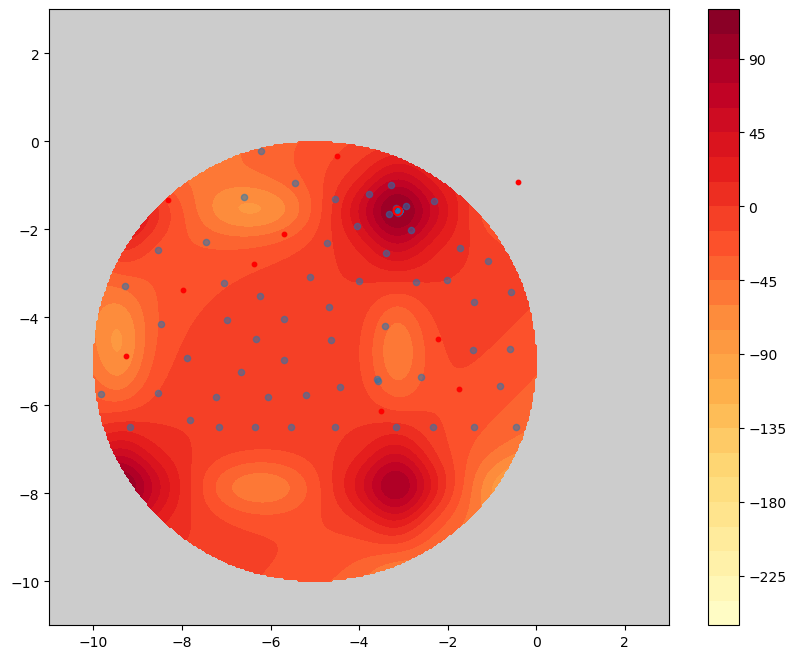

In [7]:
# PLOT THE RESULTS


resultsdf = pd.read_csv('results.csv', usecols=['x','y','target'])
first50 = pd.read_csv('results.csv', usecols=['x','y']).iloc[:ninit]
resultsdf = resultsdf.iloc[ninit:].reset_index(drop = True)

# mask = np.where(resultsdf['target'] <= 2.002)[0]
x_iter = resultsdf['x']#.iloc[mask]
y_iter = resultsdf['y']#.iloc[mask]
# plt.hist(x_iter)
# meshgrid
x = np.linspace(-11, 3, 400)
y = np.linspace(-11, 3, 400)
X, Y = np.meshgrid(x, y)

Z_target = target(X, Y)
Z_constraint = constraint(X, Y)

# target contour levels
plt.figure(figsize=(10, 8))
contour_target = plt.contourf(X, Y, Z_target, levels=25,cmap='YlOrRd') # Use 100 levels for smooth gradients
plt.colorbar(contour_target)

# constraint contour levels (only 2: >0 or <=0)
# grey for <= 0, transparent for > 0
plt.contourf(X, Y, Z_constraint <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
# plt.contourf(X, Y, Z_constraint2 <= 0, levels=[-np.inf, 0, np.inf], colors=['0.8', 'none'])
plt.scatter(x_iter, y_iter, s=20, alpha = 0.5)
#plt.scatter(-6.4139970688576815, -1.5326291848621914, color = 'black')
plt.scatter(-3.1302468, -1.5821422, edgecolors='red', facecolors='none', linewidths=1.5)
plt.scatter(first50['x'],first50['y'],s = 10, color = 'red')